# Second attempt at a world model
## Basic Process

In [1]:
# Settings and setup
import tensorflow as tf

for gpu in tf.config.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(gpu, True)

# Main Settings
ROLE = "TAGGER"

# Encoder Settings
IMG_INPUT_SHAPE=(640, 640, 3)

NUM_DBS = 8
NUM_LAYERS_PER_DB = 1
NUM_FILTERS_PER_LAYER_OF_DB = 2

DOWNSCALING_LAYERS = 4
DOWNSCALING_FACTOR = 2
OUTPUT_SIZE = 64
ENC_DROPOUT = 0.50

# PREDICTOR
PRED_INTER_LAYERS = 4
PRED_INTER_LAYER_SIZE = 256
PRED_DROPOUT = 0.1
PRED_POSSIBLE_OUTCOMES = 4

# Action Generator Settings
ACTIONS = 1
ACT_INTER_LAYERS = 5
ACT_INTER_LAYER_SIZE = 1024
ACT_DROPOUT = 0.1

# Cost Calculator Settings
CC_INTER_LAYERS = 4
CC_INTER_LAYER_SIZE = 256
CC_DROPOUT = 0.1

2023-10-13 00:38:08.666548: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-13 00:38:08.716935: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-13 00:38:09.614200: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Encoder

In [2]:
# Image segmenter base
from tensorflow.keras import layers, models

def create_dense_block(x, num_of_layers, num_filters, kernel_size=5):
    output_layers = [x]
    for l in range(num_of_layers):
        x = layers.Conv2D(num_filters, kernel_size, activation="elu", padding="same")(x)
        output_layers.append(x)
        x = layers.Concatenate()(output_layers)
    return x

def create_transistion_down(x, layer_size_change, num_filters=None):
    if num_filters:
        x = layers.Conv2D(num_filters, 1, activation="elu", padding="same")(x)
    
    return layers.MaxPool2D(layer_size_change)(x)

# Keep track for skip connections and other things
skip_connections = []
previous_filters = [NUM_LAYERS_PER_DB * NUM_FILTERS_PER_LAYER_OF_DB]

# Num of filters: 4 (layers) * 32 (idk) + 64 (previous filters)
# Should prob figure out why this is

model_in = layers.Input(shape=IMG_INPUT_SHAPE)
x = layers.Conv2D(previous_filters[-1], 9, activation="elu", padding="same")(model_in)

for i in range(NUM_DBS):
    previous_filters.append(NUM_LAYERS_PER_DB * NUM_FILTERS_PER_LAYER_OF_DB + previous_filters[-1])
    x = create_dense_block(x, NUM_LAYERS_PER_DB, previous_filters[-1])
    skip_connections.append(x)
    x = create_transistion_down(x, 2, num_filters=(previous_filters[-1]))


previous_filters.append(NUM_LAYERS_PER_DB * NUM_FILTERS_PER_LAYER_OF_DB + previous_filters[-1])
x = create_dense_block(x, NUM_LAYERS_PER_DB, previous_filters[-1]) 

dense_net = models.Model(model_in, x)

dense_net.summary()

2023-10-13 00:38:10.986427: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22257 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:18:00.0, compute capability: 8.9
2023-10-13 00:38:10.986949: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22451 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:af:00.0, compute capability: 8.6


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 640, 640, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 640, 640, 2)          488       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 640, 640, 4)          204       ['conv2d[0][0]']              
                                                                                                  
 concatenate (Concatenate)   (None, 640, 640, 6)          0         ['conv2d[0][0]',              
                                                                     'conv2d_1[0][0]']        

In [3]:
# Encoder (Simple downscaler)

# Added encoder to flatten dense_net
encoder = models.Sequential()
encoder.add(layers.Input(shape=IMG_INPUT_SHAPE))
encoder.add(layers.RandomFlip())
encoder.add(dense_net)
encoder.add(layers.Flatten())

for i in range(DOWNSCALING_LAYERS + 1):
    encoder.add(layers.Dense(DOWNSCALING_FACTOR**(DOWNSCALING_LAYERS-i) * OUTPUT_SIZE, activation="elu",)) # kernel_regularizer='l2'))
    encoder.add(layers.Dropout(ENC_DROPOUT))

encoder.add(layers.BatchNormalization())
encoder.summary()

# Make it generate PRED_POSSIBLE_OUTCOMES identical encodings to match new prediction architecture
model_in = layers.Input(shape=IMG_INPUT_SHAPE)
new_encoder = encoder(model_in)
new_encoder = tf.expand_dims(new_encoder, axis=1)
new_encoder = tf.repeat(new_encoder, repeats=PRED_POSSIBLE_OUTCOMES, axis=1)

encoder = models.Model(model_in, new_encoder)

encoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip (RandomFlip)    (None, 640, 640, 3)       0         
                                                                 
 model (Functional)          (None, 2, 2, 38)          35780     
                                                                 
 flatten (Flatten)           (None, 152)               0         
                                                                 
 dense (Dense)               (None, 1024)              156672    
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0

# Predictor

In [4]:
class ModulateEncodedFrame(layers.Layer):
    def call(self, inputs):
        return (inputs[:, 0] * inputs[:, 1]) + inputs[:, 2]

# Build previous model, but only to calculate modulations based on input
predictor = models.Sequential()
predictor.add(layers.Input(shape=ACTIONS))

# Add internal layers
for _ in range(PRED_INTER_LAYERS):
    predictor.add(layers.Dense(PRED_INTER_LAYER_SIZE, activation="elu",)) # kernel_regularizer='l2'))
    predictor.add(layers.Dropout(PRED_DROPOUT))

# Add final layers that convert these to encoding modulation vectors
predictor.add(layers.Dense(2 * PRED_POSSIBLE_OUTCOMES * OUTPUT_SIZE, activation="elu"))

# Make final new architecture
encoded_frame = layers.Input(shape=(PRED_POSSIBLE_OUTCOMES, OUTPUT_SIZE))
keys = layers.Input(shape=ACTIONS)
new_predictor = predictor(keys)
new_predictor = tf.reshape(new_predictor, (tf.shape(encoded_frame)[0], 2, PRED_POSSIBLE_OUTCOMES, OUTPUT_SIZE))
new_predictor = tf.concat([tf.expand_dims(encoded_frame, axis=1), new_predictor], axis=1)
new_predictor = ModulateEncodedFrame()(new_predictor)
new_predictor = layers.BatchNormalization()(new_predictor)

predictor = models.Model([encoded_frame, keys], new_predictor)

predictor.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 4, 64)]              0         []                            
                                                                                                  
 input_6 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 tf.compat.v1.shape (TFOpLa  (3,)                         0         ['input_5[0][0]']             
 mbda)                                                                                            
                                                                                                  
 sequential_1 (Sequential)   (None, 512)                  329472    ['input_6[0][0]']       

# Cost Calculator

In [5]:
cost_calculator = models.Sequential()
cost_calculator.add(layers.Input(shape=OUTPUT_SIZE))

# Add internal layers
for _ in range(CC_INTER_LAYERS):
    cost_calculator.add(layers.Dense(CC_INTER_LAYER_SIZE, activation="elu",)) # kernel_regularizer='l2'))
    cost_calculator.add(layers.Dropout(CC_DROPOUT))

cost_calculator.add(layers.Dense(CC_INTER_LAYER_SIZE//2, activation="elu"))
cost_calculator.add(layers.Dense(CC_INTER_LAYER_SIZE//4, activation="elu"))
cost_calculator.add(layers.Dense(1, activation="sigmoid")), # activation="elu"))

cost_calculator.summary()

# Make it take and output PRED_POSSIBLE_OUTCOMES to match new prediction architecture
model_in = layers.Input(shape=(PRED_POSSIBLE_OUTCOMES, OUTPUT_SIZE))
new_cost_calculator = tf.reshape(model_in, (tf.shape(model_in)[0] * PRED_POSSIBLE_OUTCOMES, OUTPUT_SIZE))
new_cost_calculator = cost_calculator(new_cost_calculator)
new_cost_calculator = tf.reshape(new_cost_calculator, (tf.shape(model_in)[0], PRED_POSSIBLE_OUTCOMES, 1))

cost_calculator = models.Model(model_in, new_cost_calculator)

cost_calculator.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 256)               16640     
                                                                 
 dropout_9 (Dropout)         (None, 256)               0         
                                                                 
 dense_11 (Dense)            (None, 256)               65792     
                                                                 
 dropout_10 (Dropout)        (None, 256)               0         
                                                                 
 dense_12 (Dense)            (None, 256)               65792     
                                                                 
 dropout_11 (Dropout)        (None, 256)               0         
                                                                 
 dense_13 (Dense)            (None, 256)              

## Action Generator

In [6]:
action_gen = models.Sequential()
action_gen.add(layers.Input(shape=OUTPUT_SIZE))

# Add internal layers
for _ in range(ACT_INTER_LAYERS):
    action_gen.add(layers.Dense(ACT_INTER_LAYER_SIZE, activation="elu"))
    action_gen.add(layers.Dropout(ACT_DROPOUT))

action_gen.add(layers.Dense(ACT_INTER_LAYER_SIZE//2, activation="elu"))
action_gen.add(layers.Dense(ACT_INTER_LAYER_SIZE//4, activation="elu"))
action_gen.add(layers.Dense(ACT_INTER_LAYER_SIZE//8, activation="elu"))
action_gen.add(layers.Dense(ACT_INTER_LAYER_SIZE//16, activation="elu"))
action_gen.add(layers.Dense(ACT_INTER_LAYER_SIZE//32, activation="elu"))
action_gen.add(layers.Dense(ACTIONS, activation="sigmoid"))
    
action_gen.summary()

# Make it take PRED_POSSIBLE_OUTCOMES to match new encoder architecture
model_in = layers.Input(shape=(PRED_POSSIBLE_OUTCOMES, OUTPUT_SIZE))
new_act_gen = action_gen(model_in[:, 0])

action_gen = models.Model(model_in, new_act_gen)
action_gen.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_17 (Dense)            (None, 1024)              66560     
                                                                 
 dropout_13 (Dropout)        (None, 1024)              0         
                                                                 
 dense_18 (Dense)            (None, 1024)              1049600   
                                                                 
 dropout_14 (Dropout)        (None, 1024)              0         
                                                                 
 dense_19 (Dense)            (None, 1024)              1049600   
                                                                 
 dropout_15 (Dropout)        (None, 1024)              0         
                                                                 
 dense_20 (Dense)            (None, 1024)             

# Training

In [7]:
# Open data and convert to tensors

In [8]:
# Settings
ENCODER_AND_COST_LR = 0.00000005
COST_LR = 0.000000001
PRED_LR = 0.000005
ACT_GEN_LR = 0.000005

MAX_EPOCHS = 200
BATCH_SIZE = 16

1696231163
1696230791
1696230905
1696231181
1696230793
1696231035
1696231057
1696231111
1696230878
1696231033
1696230919
1696230750
1696231002
1696230941
1696230868
1696230488
1696230839
1696230708
1696230833
1696230994
1696230461
1696231023
1696230798
1696230716
1696230485
1696230434
1696230818
1696231205
1696231120
1696231178
1696231107
1696230453
1696230854
1696230530
1696230768
1696230735
1696230714
1696231071
1696230887
1696231092
1696231211
1696231021
1696231194
1696231185
1696230944
1696231116
1696231203
1696231164
1696230780
1696230533
1696230997
1696230921
1696231018
1696231097
1696230400
1696230481
1696231123
1696231016
1696230984
1696231075
1696230837
1696230992
1696230829
1696230986
1696230427
1696231216
1696231067
1696230425
1696230457
1696230963
1696230525
1696231156
1696231138
1696231151
1696231135
1696231224
1696231004
1696230908
1696230762
1696230772
1696230849
1696230419
1696230442
1696231144
1696231054
1696230901
1696231227
1696231000
1696231199
1696231065
1696230463

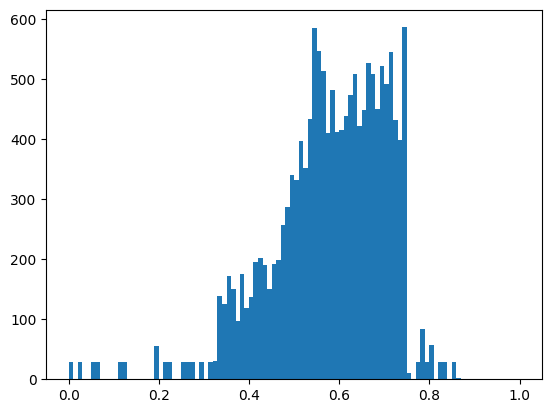

In [9]:
# Create dataset
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler

with tf.device("cpu:0"):
    runs = pd.read_csv("game_runs.csv")[["Run", "Winner"]].sample(frac=1).values.tolist()
    all_frames = []
    all_next_frames = []
    all_input = []
    all_scores = []
    for run, winner in runs[:125]:
        frames = tf.cast(tf.io.parse_tensor(tf.io.read_file("runs/%d/frames.proto_tensor" % run), tf.uint8), tf.float16)/255.0
        all_frames.append(frames)
    
        if ROLE == "TAGGER":
            all_input.append(tf.io.parse_tensor(tf.io.read_file("runs/%d/tagger_inputs.proto_tensor" % run), float))
        else:
            all_input.append(tf.io.parse_tensor(tf.io.read_file("runs/%d/taggee_inputs.proto_tensor" % run), float))
    
        tagger_poses = tf.io.parse_tensor(tf.io.read_file("runs/%d/tagger_poses.proto_tensor" % run), float)
        taggee_poses = tf.io.parse_tensor(tf.io.read_file("runs/%d/taggee_poses.proto_tensor" % run), float)
    
        scores_normalizer = tf.math.sqrt(tf.cast(tf.math.square(IMG_INPUT_SHAPE[0]) + tf.math.square(IMG_INPUT_SHAPE[1]), float)) / 3
        
        if ROLE == "TAGGER":
            scores = tf.math.sqrt(tf.math.reduce_sum(tf.math.square(tagger_poses - taggee_poses), axis=1))/scores_normalizer
        else:
            scores = (scores_normalizer - tf.math.sqrt(tf.math.reduce_sum(tf.math.square(tagger_poses - taggee_poses), axis=1)))/scores_normalizer
        
        if winner != ROLE:
            # Set all last scores to be 1
            # scores = tf.concat([scores[:-5:], tf.repeat(tf.constant([1.0]), repeats=5)], axis=0)
            
            # Make scores at the end more linear (also use 30 instead of 5)
            dist = 1.0 - scores[-30].numpy()
            smoothed_end = [scores[-30].numpy() + (dist / 30 * (i + 1)) for i in range(30)]
            scores = tf.concat([scores[:-30:], tf.constant(smoothed_end, float)], axis=0)

        all_scores.append(scores)
        print(run)

    # Just add scores
    all_next_frames = tf.concat([frame[1:] for frame in all_frames], axis=0)
    all_frames = tf.concat([frame[:-1] for frame in all_frames], axis=0)
    all_input = tf.cast(tf.concat([input[:-1] for input in all_input], axis=0), tf.float16)
    all_scores = tf.expand_dims(tf.cast(tf.concat([scores[:-1] for scores in all_scores], axis=0), tf.float16), axis=-1)

    # Add score deltas
    # all_next_frames = tf.concat([frame[2:] for frame in all_frames], axis=0)
    # all_frames = tf.concat([frame[1:-1] for frame in all_frames], axis=0)
    # all_input = tf.cast(tf.concat([input[1:-1] for input in all_input], axis=0), tf.float16)
    # all_scores = tf.expand_dims(tf.cast(tf.concat([scores[1:-1] for scores in all_scores], axis=0) - tf.concat([scores[:-2] for scores in all_scores], axis=0), tf.float16), axis=-1)
    
    # Normalize all scores
    all_scores = tf.cast(tf.numpy_function(lambda x: RobustScaler().fit_transform(x), [all_scores], float), tf.float16)
    all_scores = (all_scores - tf.math.reduce_min(all_scores, keepdims=True)) / (tf.math.reduce_max(all_scores, keepdims=True) - tf.math.reduce_min(all_scores, keepdims=True))
    
    # Sum the inputs
    mult_inputs = tf.constant([[1.0, -1]], tf.float16)
    print(all_input.shape, mult_inputs.shape)
    all_input *= mult_inputs
    all_input = tf.math.reduce_sum(all_input, axis=-1, keepdims=True)
    
    print(tf.shape(all_frames), tf.shape(all_next_frames), tf.shape(all_input), tf.shape(all_scores))
    print(tf.math.reduce_max(all_scores), tf.math.reduce_min(all_scores))

    # Plot histogram of scores
    plt.hist(all_scores[:, 0].numpy(), bins=100)
    plt.show()

    # Make DS
    big_train_ds = tf.data.Dataset.from_tensor_slices((all_frames, all_next_frames, all_input, all_scores))
    big_train_ds = big_train_ds.shuffle(big_train_ds.cardinality())
    big_valid_ds = big_train_ds.shard(8, 6)
    big_test_ds = big_train_ds.shard(8, 7)
    big_train_ds = big_train_ds.take((6 * big_train_ds.cardinality())//8)

In [10]:
# Train cost calculator and encoder
from tensorflow.keras import optimizers

# Comment out these two lines to train the encoder from scratch
# encoder = tf.keras.models.load_model("encoder_%s.keras" % ROLE)
# encoder.trainable = False

enc_cost_calc = models.Sequential([layers.Input(shape=IMG_INPUT_SHAPE), encoder, cost_calculator])
enc_cost_calc.compile(optimizers.Adam(learning_rate=ENCODER_AND_COST_LR), loss="mse", metrics=["mse"])
enc_cost_calc.summary()

frame_and_score = lambda w, x, y, z: (w, tf.repeat(tf.expand_dims(z, axis=1), repeats=PRED_POSSIBLE_OUTCOMES, axis=1))

enc_cost_calc.fit(
    big_train_ds.map(frame_and_score, num_parallel_calls=tf.data.AUTOTUNE, deterministic=False).batch(BATCH_SIZE),
    validation_data=big_valid_ds.map(frame_and_score, num_parallel_calls=tf.data.AUTOTUNE, deterministic=False).batch(BATCH_SIZE),
    epochs=MAX_EPOCHS,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=MAX_EPOCHS//10, restore_best_weights=True)]
)

encoder.save("encoder_%s.keras" % ROLE)

encoder.trainable = False

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_1 (Functional)        (None, 4, 64)             889988    
                                                                 
 model_3 (Functional)        (None, 4, 1)              255233    
                                                                 
Total params: 1145221 (4.37 MB)
Trainable params: 1145093 (4.37 MB)
Non-trainable params: 128 (512.00 Byte)
_________________________________________________________________
Epoch 1/200


2023-10-13 00:39:43.974524: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8904
2023-10-13 00:39:44.139849: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:231] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.9
2023-10-13 00:39:44.139886: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:234] Used ptxas at ptxas
2023-10-13 00:39:44.139941: W tensorflow/compiler/xla/stream_executor/gpu/redzone_allocator.cc:318] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2023-10-13 00:39:45.186556: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-10-13 00:39:45.226762: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x82669a0 ini

729/729 [==============================] - 62s 67ms/step - loss: 0.0414 - mse: 0.0414 - val_loss: 0.0236 - val_mse: 0.0236
Epoch 2/200
729/729 [==============================] - 31s 43ms/step - loss: 0.0399 - mse: 0.0399 - val_loss: 0.0233 - val_mse: 0.0233
Epoch 3/200
729/729 [==============================] - 31s 43ms/step - loss: 0.0389 - mse: 0.0389 - val_loss: 0.0242 - val_mse: 0.0242
Epoch 4/200
729/729 [==============================] - 31s 43ms/step - loss: 0.0389 - mse: 0.0389 - val_loss: 0.0236 - val_mse: 0.0236
Epoch 5/200
729/729 [==============================] - 31s 42ms/step - loss: 0.0377 - mse: 0.0377 - val_loss: 0.0227 - val_mse: 0.0227
Epoch 6/200
729/729 [==============================] - 32s 44ms/step - loss: 0.0368 - mse: 0.0368 - val_loss: 0.0232 - val_mse: 0.0232
Epoch 7/200
729/729 [==============================] - 31s 42ms/step - loss: 0.0371 - mse: 0.0371 - val_loss: 0.0227 - val_mse: 0.0227
Epoch 8/200
729/729 [==============================] - 31s 43ms/ste

In [11]:
# Train cost calculator with multiple different encodings

# cost_calculator = tf.keras.models.load_model("cost_calculator_%s.keras" % ROLE)

cost_calculator.compile(optimizers.Adam(learning_rate=ENCODER_AND_COST_LR), loss="mse", metrics=["mse"])
cost_calculator.summary()

encodings_and_score = lambda w, x, y, z: (encoder(w)[:, 0], z)

encoding_cost_train_ds = big_train_ds.batch(BATCH_SIZE * PRED_POSSIBLE_OUTCOMES, drop_remainder=True).map(encodings_and_score, num_parallel_calls=tf.data.AUTOTUNE, deterministic=False)
encoding_cost_train_ds = encoding_cost_train_ds.unbatch().shuffle(encoding_cost_train_ds.cardinality()).cache()
encoding_cost_valid_ds = big_valid_ds.batch(BATCH_SIZE * PRED_POSSIBLE_OUTCOMES, drop_remainder=True).map(encodings_and_score, num_parallel_calls=tf.data.AUTOTUNE, deterministic=False)
encoding_cost_valid_ds = encoding_cost_valid_ds.unbatch().shuffle(encoding_cost_valid_ds.cardinality()).cache()

cost_calculator.fit(
    encoding_cost_train_ds.batch(PRED_POSSIBLE_OUTCOMES).batch(BATCH_SIZE),
    validation_data=encoding_cost_valid_ds.batch(PRED_POSSIBLE_OUTCOMES).batch(BATCH_SIZE),
    epochs=MAX_EPOCHS,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=MAX_EPOCHS//10, restore_best_weights=True)]
)

cost_calculator.save("cost_calculator_%s.keras" % ROLE)

cost_calculator.trainable = False

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 4, 64)]              0         []                            
                                                                                                  
 tf.compat.v1.shape_1 (TFOp  (3,)                         0         ['input_8[0][0]']             
 Lambda)                                                                                          
                                                                                                  
 tf.__operators__.getitem_1  ()                           0         ['tf.compat.v1.shape_1[0][0]']
  (SlicingOpLambda)                                                                               
                                                                                            

In [12]:
# Train prediction

def minimum_mse(y_true, y_pred):
    se = tf.math.square(y_true - y_pred)
    mse = tf.math.reduce_mean(se, axis=2) # because axis 0 is batch and 1 is the 4 predictions
    return tf.math.reduce_mean(tf.math.reduce_min(mse, axis=1)) # because axis 0 is batch

with tf.device("cpu:0"):
    apply_encoder = lambda w, x, y, z: ((tf.cast(encoder(w), tf.float16), y[:, :]), tf.cast(encoder(x), tf.float16))
    pred_train_ds = big_train_ds.batch(BATCH_SIZE).map(apply_encoder, num_parallel_calls=tf.data.AUTOTUNE, deterministic=False).cache()
    pred_valid_ds = big_valid_ds.batch(BATCH_SIZE).map(apply_encoder, num_parallel_calls=tf.data.AUTOTUNE, deterministic=False).cache()

with tf.device("gpu:0"):
    predictor.compile(optimizers.Adam(learning_rate=PRED_LR), loss=minimum_mse, metrics=[minimum_mse, "mse"])
    predictor.summary()
    
    predictor.fit(
        pred_train_ds,
        validation_data=pred_valid_ds,
        epochs=MAX_EPOCHS,
        callbacks=[tf.keras.callbacks.EarlyStopping(patience=MAX_EPOCHS//10, restore_best_weights=True)]
    )

predictor.trainable=False

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 4, 64)]              0         []                            
                                                                                                  
 input_6 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 tf.compat.v1.shape (TFOpLa  (3,)                         0         ['input_5[0][0]']             
 mbda)                                                                                            
                                                                                                  
 sequential_1 (Sequential)   (None, 512)                  329472    ['input_6[0][0]']       

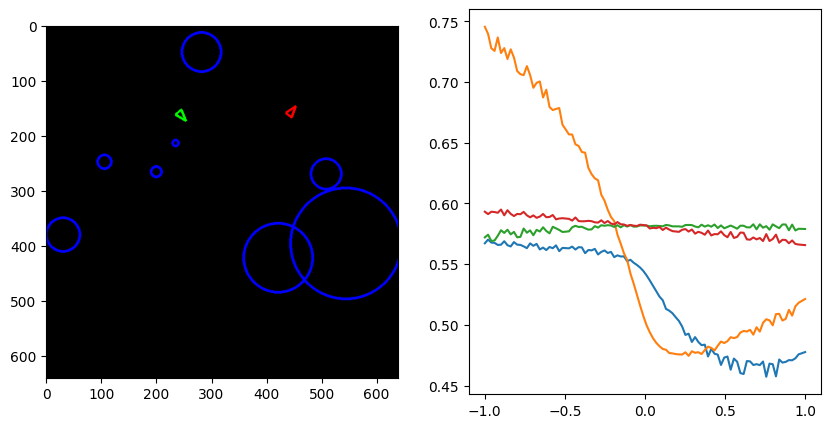

0.532 [[0.56466615]]


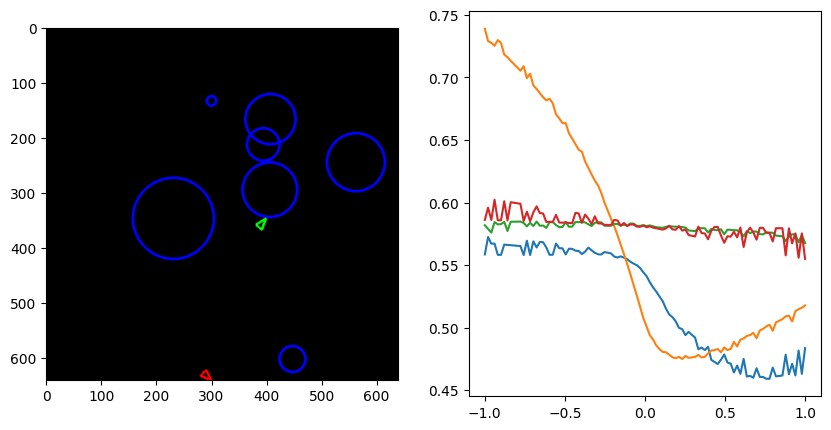

0.669 [[0.5635194]]


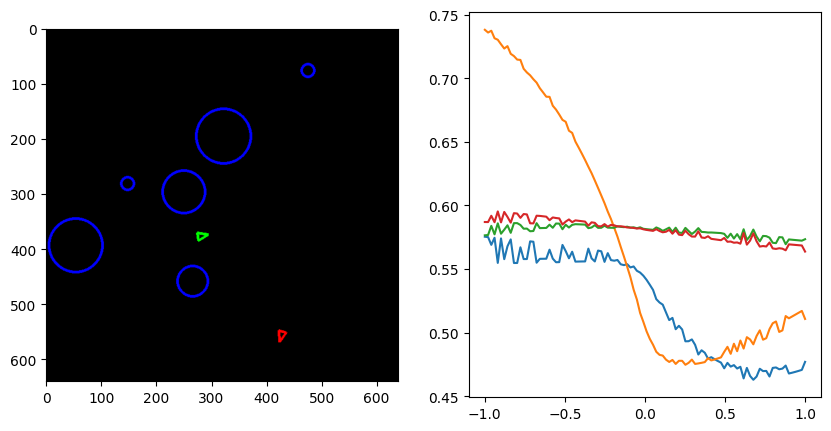

0.529 [[0.56768864]]


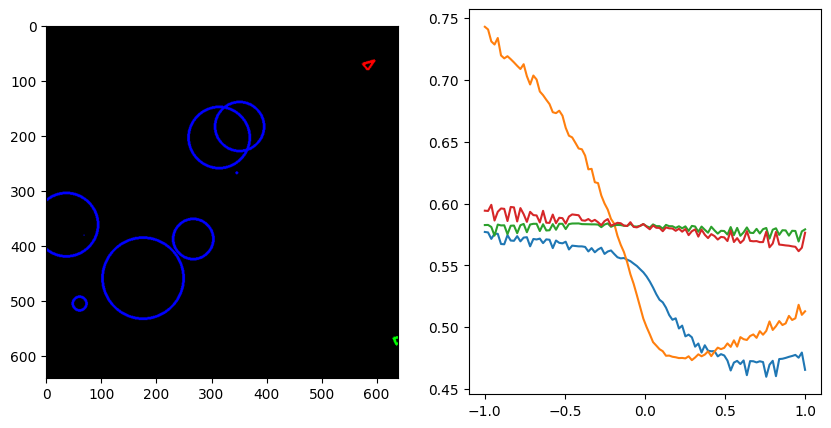

0.559 [[0.5709818]]


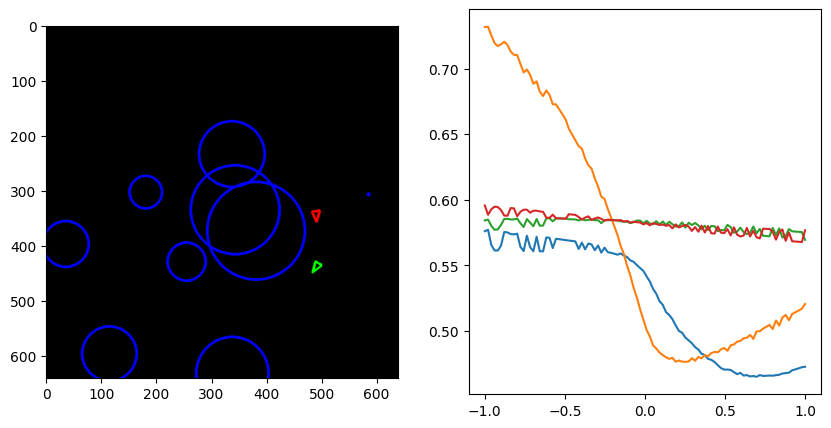

0.513 [[0.58443457]]


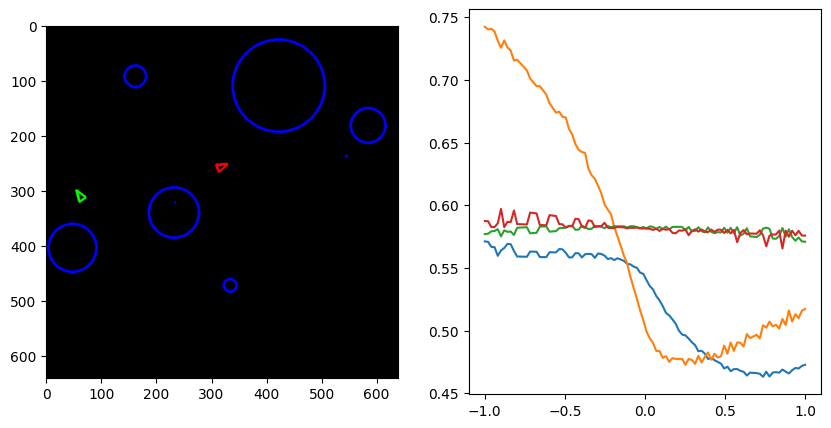

0.683 [[0.5770111]]


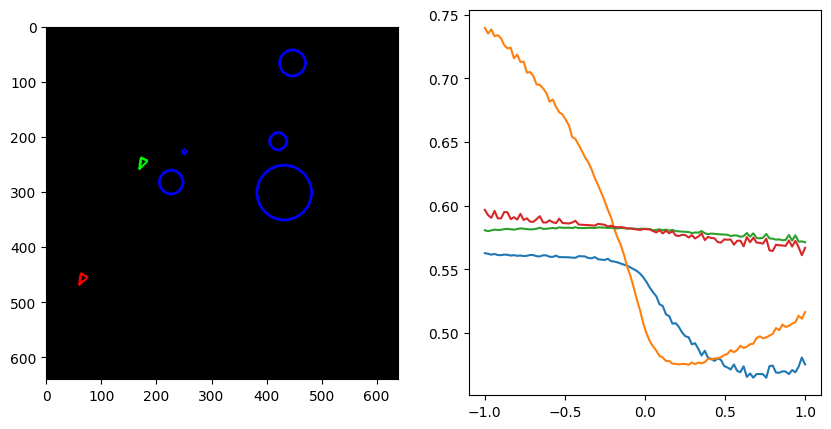

0.5483 [[0.5704265]]


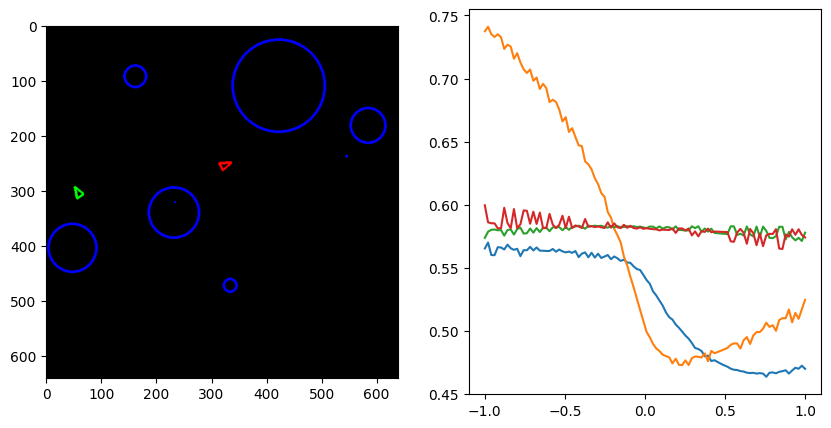

0.6714 [[0.5743331]]


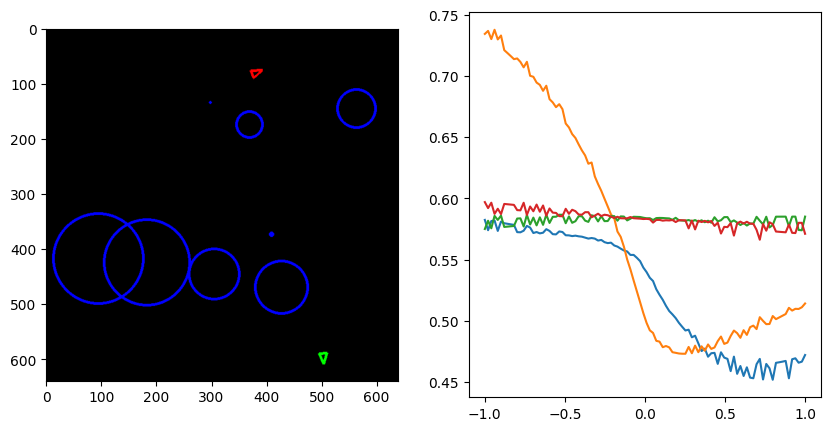

0.646 [[0.5924402]]


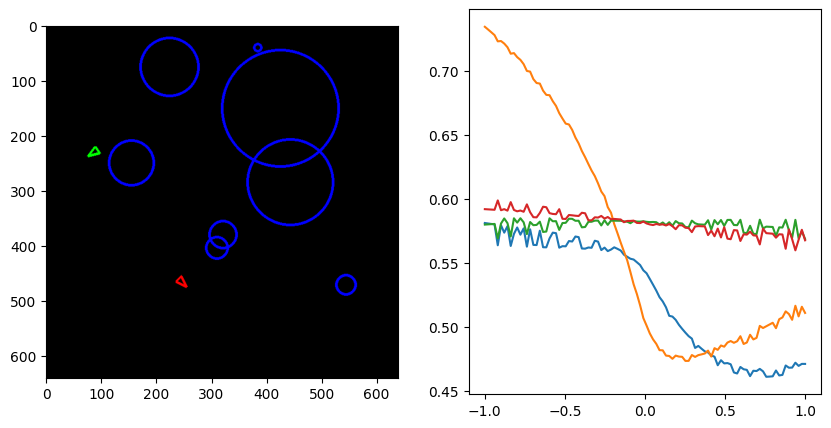

0.64 [[0.58678937]]


In [13]:
# Plot sanity test: how does turning effect score
import matplotlib.pyplot as plt

test_cc_ds = big_valid_ds.take(10)

# cost_calculator(predictor(
for element in test_cc_ds:
    fig, ax = plt.subplots(1, 2, figsize=(10,5))
    ax[0].imshow(element[0].numpy().astype(float))

    actions = tf.expand_dims(tf.linspace(-1, 1, 100), axis=-1)
    act_results = tf.map_fn(lambda x: cost_calculator(predictor((encoder(tf.expand_dims(element[0], axis=0)), x))), actions, fn_output_signature=float)
    ax[1].plot(actions[:, 0], act_results[:, 0, :, 0])

    plt.show()

    print(element[3][0].numpy(), cost_calculator(encoder(tf.expand_dims(element[0], axis=0)))[:, 0, :].numpy())

In [1]:
# Train action generator
def minimize_loss(y_true, y_pred):
    return tf.math.reduce_mean(y_pred)

with tf.device("cpu:0"):
    apply_encoder = lambda w, x, y, z: (tf.cast(encoder(w), tf.float16), z)
    actgen_valid_ds = big_valid_ds.batch(BATCH_SIZE).map(apply_encoder, num_parallel_calls=BATCH_SIZE//4, deterministic=False).cache()
    actgen_train_ds = tf.data.Dataset.from_tensor_slices((tf.random.normal((100_000, PRED_POSSIBLE_OUTCOMES, OUTPUT_SIZE)), tf.zeros(100_000, 1))).batch(BATCH_SIZE)

print(actgen_train_ds)
print(actgen_valid_ds)

model_in = layers.Input(shape=(PRED_POSSIBLE_OUTCOMES, OUTPUT_SIZE))
action_gen_trainer = predictor((model_in, action_gen(model_in)))
action_gen_trainer = cost_calculator(action_gen_trainer)
action_gen_trainer = models.Model(model_in, action_gen_trainer)

action_gen_trainer.compile(optimizers.Adam(learning_rate=ACT_GEN_LR), loss=minimize_loss, metrics=[minimize_loss])
action_gen_trainer.summary(show_trainable=True)

action_gen_trainer.fit(
    actgen_train_ds,
    validation_data=actgen_valid_ds,
    epochs=MAX_EPOCHS,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=MAX_EPOCHS//10, restore_best_weights=True)]
)

NameError: name 'tf' is not defined

In [ ]:
# Save model so it can play the game

pred_model = models.Sequential([layers.Input(shape=IMG_INPUT_SHAPE), encoder, action_gen])
pred_model.save("prediction_model_%s.keras" % ROLE)